# Argoverse Test

The following tests contain the evaluation of Explainable Boosting Machines (EBM) on [Argoverse](https://www.argoverse.org/av2.html#forecasting-link) motion forcasting dataset. 
Interestingly, without dense road network data, the model give 3.88 m of final error for 6 modes (comparing with state-of-the-art of around 1 m).

The code assume existance of argoverse dataset files extracted in a neighbour folder.

# New Features

In [1]:
import numpy as np
import pandas as pd
import glob,os
from pathlib import Path
from scipy import stats

from pygam import LinearGAM, s, f,l,te, ExpectileGAM

from multiprocessing import Pool
from av2.map.map_api import ArgoverseStaticMap

from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline

# Load files

Format is
 4 x, 4y, 5 in_vx, 5 in_vy, h,t, 4 ttc, 6 out_x, 6 out_y, (24*2: (xy pairs) map)


In [2]:
XsYsval = np.load('XsYs_pet_gc_val_v1.npy') # X,84
# 4 x, 4y, 5 in_vx, 5 in_vy, h,t, 4 ttc, 6 out_x, 6 out_y, (24*2: (xy pairs) map)
Ys_all_val = XsYsval[:,24:36]
Ys_val = Ys_all_val[:,[5,11]]
Xs_val = XsYsval[:,:24] # no maps
Xs_maps_val = XsYsval[:,36:] 

XsYs = np.load('XsYs_pet_gc_train_v1.npy') # X,84
# 4 x, 4y, 5 in_vx, 5 in_vy, h,t, 4 ttc, 6 out_x, 6 out_y, (24*2: (xy pairs) map)
Ys_all = XsYs[:,24:36]
Ys = Ys_all[:,[5,11]]
Xs = XsYs[:,:24] # no maps
Xs_maps = XsYs[:,36:] 

In [4]:
maps_cnts = np.array([[-5.14150e+01,  2.00000e-02],
       [-5.48700e+01, -2.30200e+01],
       [-1.81400e+01,  5.16500e+01],
       [ 1.21150e+01,  0.00000e+00],
       [ 1.21150e+01, -3.26650e+01],
       [ 1.21200e+01,  3.71950e+01],
       [ 2.10650e+01,  0.00000e+00],
       [ 2.10650e+01, -3.95800e+01],
       [ 2.10650e+01,  3.58100e+01],
       [ 3.11850e+01,  5.00000e-03],
       [ 3.11850e+01, -3.08000e+01],
       [ 3.11850e+01,  3.78950e+01],
       [ 4.18200e+01, -1.00000e-02],
       [ 4.18250e+01, -3.32950e+01],
       [ 4.18250e+01,  3.52200e+01],
       [ 5.26450e+01,  0.00000e+00],
       [ 5.26350e+01, -3.17000e+01],
       [ 5.26450e+01,  3.03650e+01],
       [ 6.51250e+01, -5.00000e-03],
       [ 6.51300e+01, -2.66250e+01],
       [ 6.51300e+01,  2.76250e+01],
       [ 1.11845e+02,  0.00000e+00],
       [ 1.09440e+02, -3.22350e+01],
       [ 1.05120e+02,  2.80750e+01]]).flatten()

Xs_maps[:,:][(Xs_maps[:,:]==maps_cnts)] = 0
Xs_maps_val[:,:][(Xs_maps_val[:,:]==maps_cnts)] = 0

# Rotate all

In [5]:

c, s_ = np.cos(Xs[:,18]), np.sin(Xs[:,18])
R_mat = np.array([[c, s_], 
                  [-s_, c]]).transpose(2,0,1)
#tranform
Ys = (np.einsum('BNi,Bi ->BN', R_mat, Ys))
for i in range(4):
    Xs[:,[i,i+4]] = np.einsum('BNi,Bi ->BN', R_mat, Xs[:,[i,i+4]])
    Xs[:,[i+8,i+13]] = np.einsum('BNi,Bi ->BN', R_mat, Xs[:,[i+8,i+13]])
    
Xs[:,[12,17]] = np.einsum('BNi,Bi ->BN', R_mat, Xs[:,[12,17]])


c, s_ = np.cos(Xs_val[:,18]), np.sin(Xs_val[:,18])
R_mat = np.array([[c, s_], [-s_, c]]).transpose(2,0,1)
Ys_val = (np.einsum('BNi,Bi ->BN', R_mat, Ys_val))
for i in [0,1,2,3]:
    Xs_val[:,[i,i+4]] = np.einsum('BNi,Bi ->BN', R_mat, Xs_val[:,[i,i+4]])
    Xs_val[:,[i+8,i+13]] = np.einsum('BNi,Bi ->BN', R_mat, Xs_val[:,[i+8,i+13]])
# speed
Xs_val[:,[12,17]] = np.einsum('BNi,Bi ->BN', R_mat, Xs_val[:,[12,17]])


# Get vehicles only

In [6]:
#types_dict = {'VEHICLE':4,'PEDESTRIAN':0,'MOTORCYCLIST':2,'CYCLIST':1,'BUS':3}
type_ = 4
mask_v = (Xs_val[:,19]==type_)
XsYsval = XsYsval[mask_v]
Ys_val = Ys_val[mask_v]
Xs_val = Xs_val[mask_v] # no maps
Xs_maps_val = Xs_maps_val[mask_v] 


mask_v = (Xs[:,19]==type_)
print(f'vehciles percentage: {100*sum(mask_v)/XsYs.shape[0]}%')
XsYs = XsYs[mask_v]
Ys = Ys[mask_v]
Xs = Xs[mask_v] # no maps
Xs_maps = Xs_maps[mask_v] 



vehciles percentage: 88.41066890769754%


# Show label data

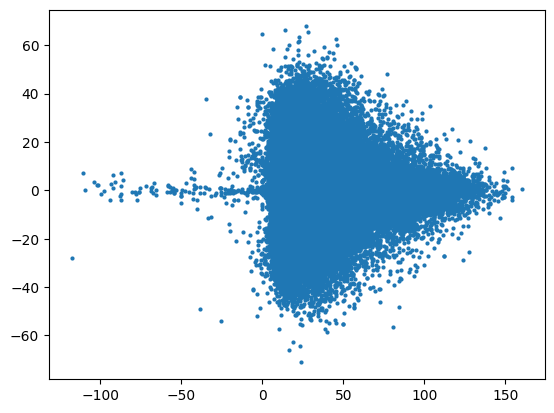

In [7]:


mask_outliers = (Ys[:,1]<75)
Ys = Ys[mask_outliers]
Xs = Xs[mask_outliers]
Xs_maps = Xs_maps[mask_outliers]
#Ys_p = Ys[kmeans.predict(Ys)==4]
plt.scatter(Ys[:,0],Ys[:,1],marker='.',linewidths=0.01)
plt.show()
# Dense modes X: [0,100]
# Dense modes Y: [-50,50]

# Single GAM

In [8]:
Ys_masked = Ys.copy()
Xs_masked = np.hstack((Xs,Xs_maps))
Ys_val_masked = Ys_val.copy()
Xs_val_masked = np.hstack((Xs_val,Xs_maps_val))


In [9]:
from sklearn.cluster import KMeans
use_kmeans = False
n_modes = 24
if use_kmeans:

    clusterer = KMeans(n_clusters=n_modes,random_state=42).fit(Ys_masked[:,:2])#,random_state=42,n_init=10
    sub_modes = []
    for i in range(n_modes):
        cluster_i = (clusterer.labels_==i)
        #print(sum(cluster_i))
        #if (sum(cluster_i))>1000:
        sub_modes.append(Ys_masked[cluster_i])
        color = np.array([[np.random.rand() for _  in range(3)]])
        plt.scatter(Ys_masked[cluster_i][:,0],Ys_masked[cluster_i][:,1],c=color,marker='.',linewidths=0.001)
    plt.show()

In [11]:
map_x = np.array([20.775646305106598,
 20.93104028609399,
 21.05146860312531,
 21.843791411066185,
 21.074766417950574,
 21.016570779069,
 21.917447223980943,
 20.708498358123844,
 21.086716388645584,
 21.70619309361271,
 21.285708965509258,
 21.584203288536738,
 21.44216998170091,
 21.986344089961726,
 21.929598997667892,
 20.694559735173268,
 22.24303021435951,
 21.83491598861273,
 19.1960089011812,
 22.08437113394659,
 21.235146703698785,
 17.55908379095713,
 19.95352114876765,
 19.059908422509988])

map_x -= map_x.min()
map_x /= map_x.max()
map_y = np.array([4.68457705, 4.62759123, 4.69970082, 4.48792953, 4.65558691,
       4.6761963 , 4.41020033, 4.65050579, 4.57087074, 4.3774534 ,
       4.57045138, 4.47114705, 4.36377177, 4.54395602, 4.44304642,
       4.35202836, 4.49518266, 4.40383455, 4.34288804, 4.45750773,
       4.37139527, 4.36040509, 4.47675049, 4.36771985])
map_y -= map_y.min()
map_y /= map_y.max()

In [41]:

f_names = ['x0','x1','x2','x3','y0','y1','y2','y3',
           'vx0','vx1','vx2','vx3','vx4','vy0','vy1','vy2','vy3','vy4',
           'heading','type','poc_left','poc_front','poc_right','poc_back']

for i in range(24):
    f_names.extend([f'mode{i}x',f'mode{i}y'])

file_name_x = 'gam_allx'
file_name_y = 'gam_ally'
if type_!=4:
    file_name_x = f'gam_allx_{type_}'
    file_name_y = f'gam_ally_{type_}'

if os.path.isfile(file_name_x)  :

    gam_allx = ExplainableBoostingRegressor()._from_json(file_name_x)
    gam_ally = ExplainableBoostingRegressor()._from_json(file_name_y)
else:
    # 4 x, 4y, 5 in_vx, 5 in_vy, h,t, 4 ttc, 6 out_x, 6 out_y, (24*2: (xy pairs) map)
    gam_allx = ExplainableBoostingRegressor(feature_names=f_names).fit(Xs_masked[:,:],(Ys_masked[:,0]))
    print('done training on x axis')
    gam_allx.to_json(file_name_x)
    gam_ally = ExplainableBoostingRegressor(feature_names=f_names).fit(Xs_masked[:,:],(Ys_masked[:,1]))
    print('done training on y axis')
    gam_ally.to_json(file_name_y)

c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\interpret\glassbox\_ebm\_json.py:407: UserWarning:

JSON formats are in beta. The JSON format may change in a future version without compatibility between releases.



# Maps only

In [13]:

f_names = []
for i in range(24):
    f_names.extend([f'mode{i}x',f'mode{i}y'])
    
file_name_x = 'gam_allx_maps'
file_name_y = 'gam_ally_maps'
if type_!=4:
    file_name_x = f'gam_allx_maps_{type_}'
    file_name_y = f'gam_ally_maps_{type_}'

if os.path.isfile(file_name_x):

    gam_allx_maps = ExplainableBoostingRegressor()._from_json(file_name_x)
    gam_ally_maps = ExplainableBoostingRegressor()._from_json(file_name_y)
else:
    # 4 x, 4y, 5 in_vx, 5 in_vy, h,t, 4 ttc, 6 out_x, 6 out_y, (24*2: (xy pairs) map)
    gam_allx_maps = ExplainableBoostingRegressor(feature_names=f_names).fit(Xs_masked[:,24:],(Ys_masked[:,0]))
    print('done training on x axis')
    gam_allx_maps.to_json(file_name_x)
    gam_ally_maps = ExplainableBoostingRegressor(feature_names=f_names).fit(Xs_masked[:,24:],(Ys_masked[:,1]))
    print('done training on y axis')
    gam_ally_maps.to_json(file_name_y)

In [14]:
global_ex_x  = gam_allx.explain_global()
global_ex_y  = gam_ally.explain_global()


local_ex_x = gam_allx.explain_local(Xs_masked[:,:])
local_ex_y = gam_ally.explain_local(Xs_masked[:,:])

show([global_ex_x,local_ex_x])

<!-- http://127.0.0.1:7001/2383773158656/ -->
 Open in new window

In [13]:
errorsx_esm = abs((gam_allx.predict(Xs_val_masked[:,:]))-(Ys_val_masked[:,0]))
errorsx_esmy = abs((gam_ally.predict(Xs_val_masked[:,:]))-(Ys_val_masked[:,1]))
print(errorsx_esm.mean())
print(errorsx_esmy.mean())

print(f'final error: {np.linalg.norm(np.vstack((errorsx_esm,errorsx_esmy)).T,axis=1).mean()}')

7.174310134624231
3.963797898207976
final error: 9.136847529997924


# Global Explaination

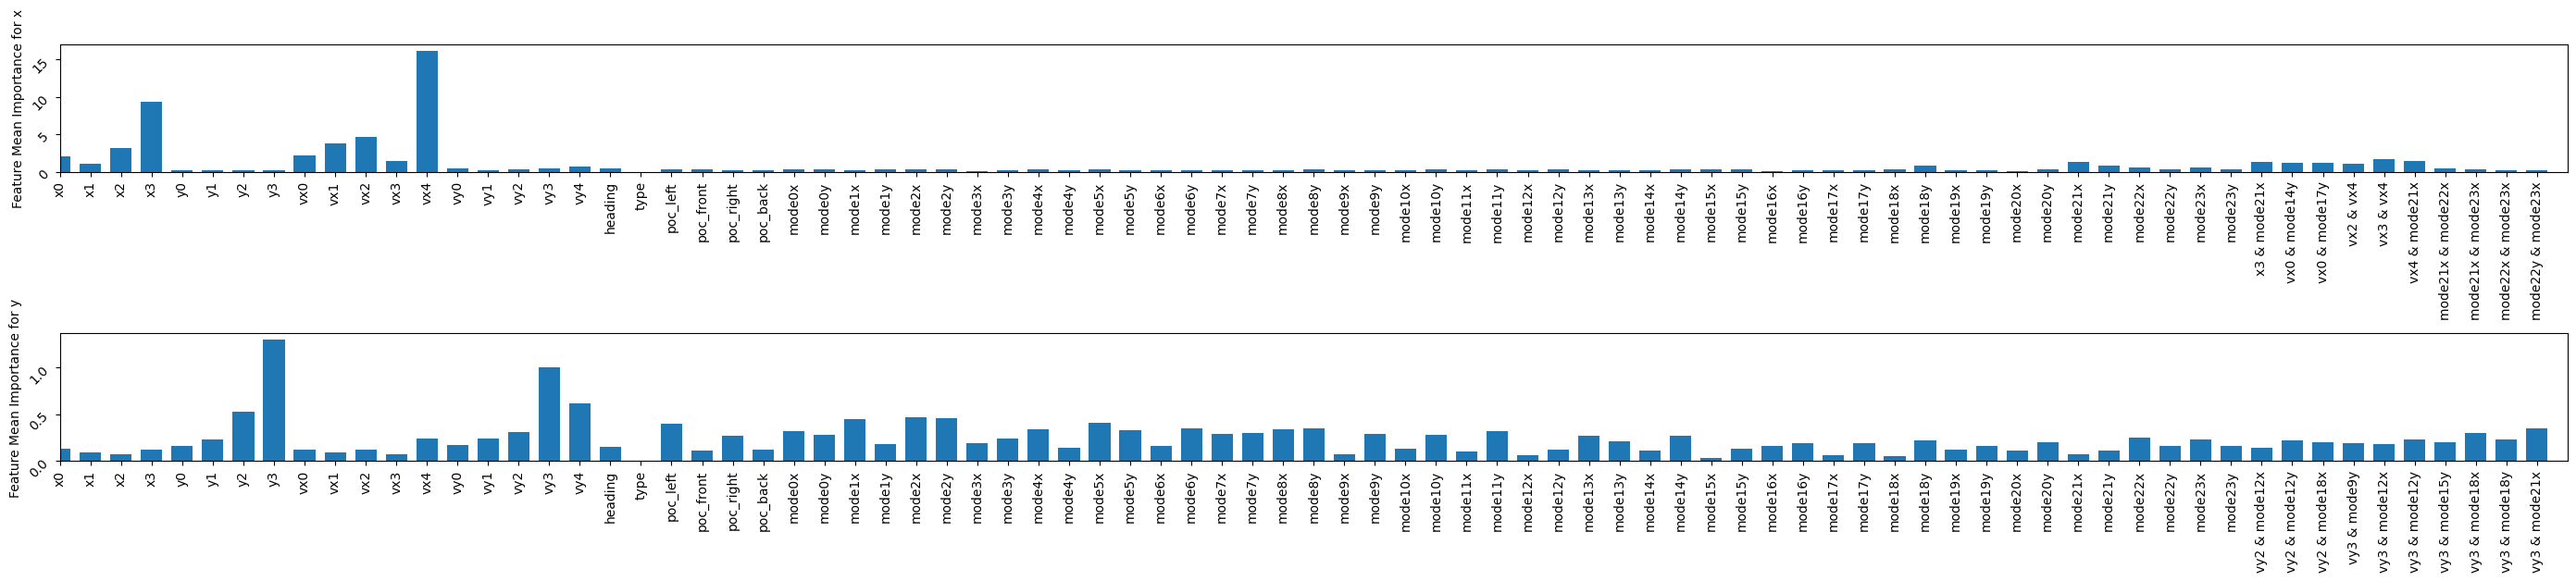

In [20]:
scores = global_ex_x.data()['scores'][0:]
names = global_ex_x.data()['names'][0:]

plt.figure(figsize=(28,6))

plt.subplot(211)
plt.bar(range(0,len(scores)*10,10),scores,width=7,align='center')
plt.xticks(np.arange(0,len(scores)*10,10),names,rotation=90)
plt.xlim(0,len(scores)*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for x')

scores = global_ex_y.data()['scores'][0:]
names = global_ex_y.data()['names'][0:]
plt.subplot(212)
plt.bar(range(0,len(scores)*10,10),scores,width=7,align='center')
plt.xticks(np.arange(0,len(scores)*10,10),names,rotation=90)
plt.xlim(0,len(scores)*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for y')

plt.tight_layout()
plt.show()

# Best 6 Features

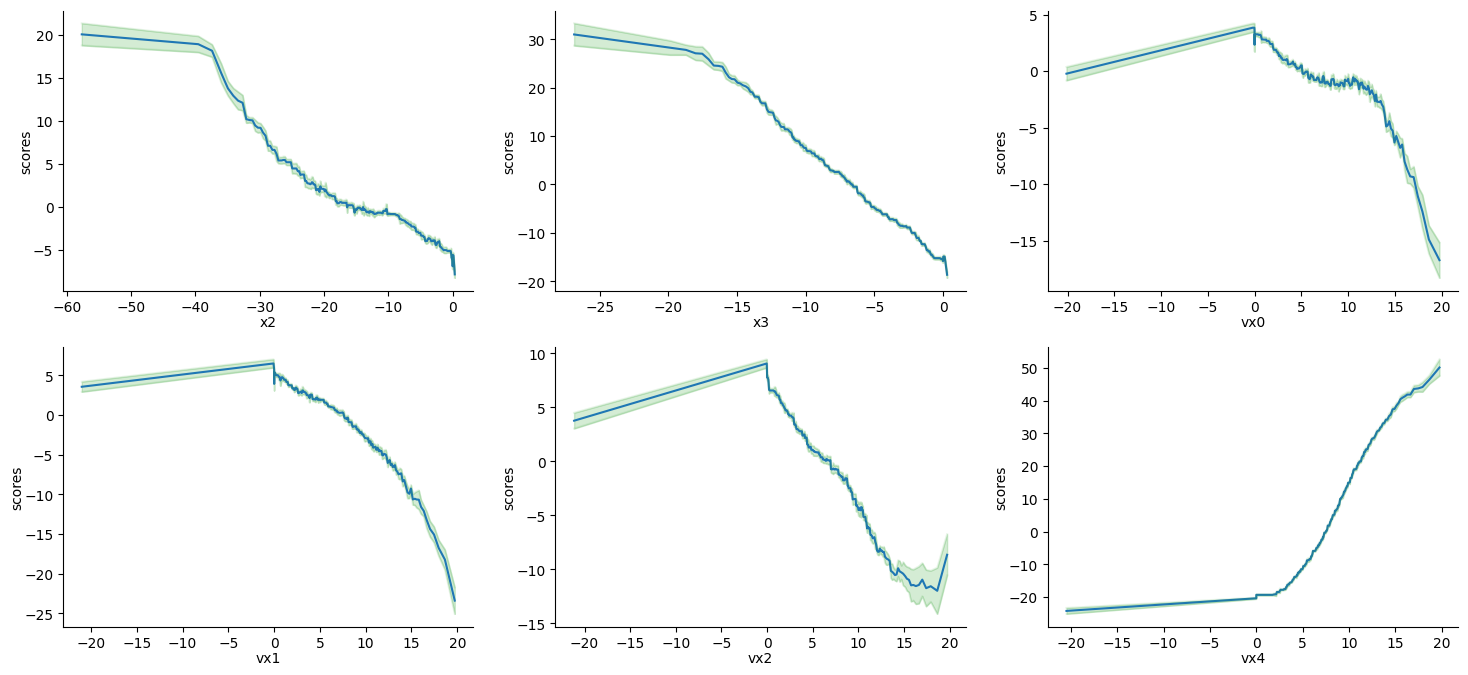

In [21]:
import seaborn as sns
names = global_ex_x.data()['names']
scores = global_ex_x.data()['scores']

best_6_mask = scores>(np.sort(scores)[-7])
p_in = 1
plt.figure(figsize=(18,8))
plt.title('Best six features dependence graphs for X model')
sigma_factor = 3
for k_i in np.arange(len(scores))[best_6_mask]:
    f_dict = global_ex_x.data(key=k_i)
    if f_dict['type']=='interaction':
        ax = plt.subplot(2,3,p_in)
        p_in += 1
        s_data = f_dict['scores'].T
        plt.imshow(s_data)
        ay_l,ax_l = names[k_i].split('&')
        plt.ylabel(ax_l,labelpad=0.5)
        plt.xlabel(ay_l,labelpad=0.1)
        plt.xticks(ticks=np.arange(len(f_dict['left_names'])),labels=np.round(f_dict['left_names'],2),rotation=90)
        plt.yticks(ticks=np.arange(len(f_dict['right_names'])),labels=np.round(f_dict['right_names'],1))
        # TODO heatmap 
    else:
        x_data = f_dict['names'][:-1]
        y_data = f_dict['scores']
        up_data = f_dict['upper_bounds']
        up_data_m = sigma_factor*(up_data-y_data) + y_data
        low_data = f_dict['lower_bounds']
        low_data_m = sigma_factor*(low_data-y_data) + y_data
        ax = plt.subplot(2,3,p_in)
        p_in += 1
        plt.plot(x_data,y_data)
        #plt.plot(x_data,up_data_m ,c='r',ls='--')
        #plt.plot(x_data,low_data_m,c='r',ls='--')
        plt.xlabel(names[k_i],labelpad=0.5)
        plt.ylabel("scores",labelpad=0.1)
        
        ax.plot(x_data, low_data_m, color='tab:green', alpha=0.1)
        ax.plot(x_data, up_data_m, color='tab:green', alpha=0.1)
        ax.fill_between(x_data, low_data_m, up_data_m,color='tab:green', alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

# Cut to equal train batches (On X):

In [32]:
YsXs = np.hstack((Ys_masked[:,:],Xs_masked[:,:]))
YsXs_test = np.hstack((Ys_val_masked[:,:],Xs_val_masked[:,:]))

x_ranges = 8
yx_sorted_x = sorted(YsXs,key=lambda x: x[0])
single_len = (len(yx_sorted_x)//x_ranges)#+(x_ranges-1)
sub_modes_x = [yx_sorted_x[(i*single_len):(i+1)*single_len] for i in range(x_ranges)]

In [33]:
new_sub_modes_x = []
acc_mode = []
acc = 0
for i,mode_x in enumerate(sub_modes_x):
    acc += (np.array(mode_x)[:,0].max()-np.array(mode_x)[:,0].min())
    acc_mode.extend(mode_x)
    #print(i,acc)
    if acc>2:
        new_sub_modes_x.append(acc_mode)
        acc_mode = []
        acc = 0

# Alternative (equal Ys)

In [34]:
y_ranges = 3
edge_len = 8
sub_modes = []
modes_index = []
min_percent = 1/(y_ranges*1)

for ix,sub_mode_x in enumerate(new_sub_modes_x):
    sub_mode_x_arr = np.array(sub_mode_x)
    sub_ys = sub_mode_x_arr[:,1]
    #assume mean 0
    center_mode = sub_mode_x_arr[(sub_ys<edge_len)*(sub_ys>-edge_len)]
    print(center_mode.shape) 
    sub_modes.append(center_mode)
    modes_index.append(center_mode[:,:2].mean(axis=0))
    
    c_mode  = sub_mode_x_arr[(sub_ys<-edge_len)]
    print(c_mode.shape) 
    sub_modes.append(c_mode)
    modes_index.append(c_mode[:,:2].mean(axis=0))
    
    c_mode  = sub_mode_x_arr[(sub_ys>edge_len)] 
    print(c_mode.shape) 
    sub_modes.append(c_mode)
    modes_index.append(c_mode[:,:2].mean(axis=0))

    
modes_index = np.array(modes_index)

(21043, 74)
(533, 74)
(516, 74)
(15082, 74)
(3726, 74)
(3284, 74)
(14917, 74)
(3077, 74)
(4098, 74)
(17048, 74)
(2265, 74)
(2779, 74)
(18740, 74)
(1566, 74)
(1786, 74)
(19837, 74)
(1142, 74)
(1113, 74)
(20578, 74)
(754, 74)
(760, 74)
(20653, 74)
(797, 74)
(642, 74)


# Show the culsters

In [35]:
modes_ranges = []
for mode in sub_modes:
    modes_ranges.append([(mode[:,0].min(),mode[:,0].max()),(mode[:,1].min(),mode[:,1].max())])

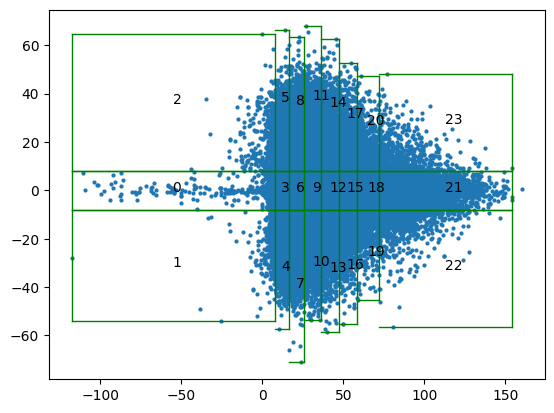

In [36]:
plt.scatter(Ys[:,0],Ys[:,1],marker='.',linewidths=0.01)
yx_range = [-150,150]

for i,sub_mode_x in enumerate(new_sub_modes_x):#x
    sub_mode = np.array(sub_mode_x)
    xmin,xmax = sub_mode[:,0].min(),sub_mode[:,0].max()
    ymin,ymax = sub_mode[:,1].min(),sub_mode[:,1].max()
    
    
    if i == 0:
        plt.plot([xmin,xmin],[ymin,ymax],'g',linewidth=1)
    plt.plot([xmax,xmax],[ymin,ymax],'g',linewidth=1)
    offset = i*y_ranges
    for j in range(y_ranges):
        mode = sub_modes[offset+j]
        #print(len(mode))
        if len(mode)==0:
            continue
        ymin,ymax = mode[:,1].min(),mode[:,1].max()
        #xmin,xmax = mode[:,0].min(),mode[:,0].max()
        #if j==(y_ranges-1):
        plt.plot([xmin,xmax],[ymin,ymin],'g',linewidth=1)
        plt.plot([xmin,xmax],[ymax,ymax],'g',linewidth=1)
        #plt.fill_between([xmin,xmax],y1=ymin,y2=ymax,color=[1-map_y[offset+j],0,0],cmap='hot',alpha=0.7)
        plt.text(x=(xmin+xmax-1)/2,y=(ymin+ymax-1)/2,s=str(offset+j),color='black')
        #print(len(mode))
plt.show()



# Split validation

In [37]:
#x_ranges = 12
yx_sorted_x = sorted(YsXs_test,key=lambda x: x[0])
single_len = (len(yx_sorted_x)//x_ranges)#+(x_ranges-1)
sub_modes_x_val = [yx_sorted_x[(i*single_len):(i+1)*single_len] for i in range(x_ranges)]
new_sub_modes_x_val = []
acc_mode = []
acc = 0
for i,mode_x in enumerate(sub_modes_x_val):
    acc += (np.array(mode_x)[:,0].max()-np.array(mode_x)[:,0].min())
    acc_mode.extend(mode_x)
    #print(i,acc)
    if acc>2:
        new_sub_modes_x_val.append(acc_mode)
        acc_mode = []
        acc = 0
        
#y_ranges = 15
sub_modes_val = []
modes_index = []
for ix,sub_mode_x in enumerate(new_sub_modes_x_val):
    yx_sorted_y = sorted(sub_mode_x,key=lambda x: x[1])
    single_len = (len(yx_sorted_y)//y_ranges)+(y_ranges-1)
    #print(len(yx_sorted_y))
    for iy in range(y_ranges):
        c_mode = np.array(yx_sorted_y[(iy*single_len):(iy+1)*single_len])
        if len(c_mode.shape)<2:
            c_mode = c_mode[:,None]
        #print(ix,iy,c_mode.shape)
        sub_modes_val.append(c_mode)
        modes_index.append(c_mode[:,:2].mean(axis=0))

    #sub_modes.extend([np.array(yx_sorted_y[(i*single_len):(i+1)*single_len]) for i in range(y_ranges)])
    
#modes_index = np.array(modes_index)

In [38]:
if use_kmeans:
    sub_modes = []
    for i in range(35):
        cluster_i = (clusterer.labels_==i)
        #print(sum(cluster_i))
        #if (sum(cluster_i))>1000:
        sub_modes.append(YsXs[cluster_i])
        color = np.array([[np.random.rand() for _  in range(3)]])
        plt.scatter(YsXs[cluster_i][:,0],YsXs[cluster_i][:,1],c=color,marker='.',linewidths=0.001)
    plt.show()

In [29]:
if use_kmeans:
    sub_modes_val = []

    val_modes = clusterer.predict(YsXs_test[:,:2])

    for m in range(24):
        mask_val = (val_modes==m)
        sub_modes_val.append(YsXs_test[mask_val])

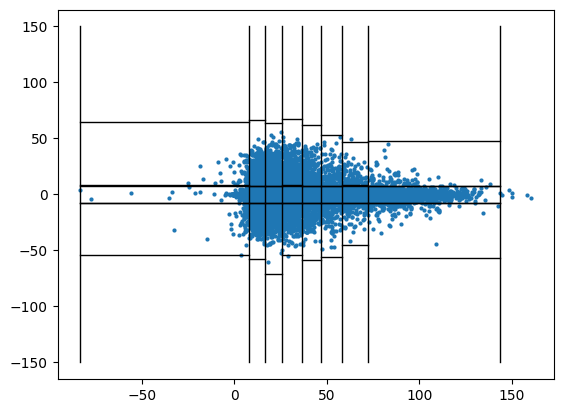

In [39]:
plt.scatter(YsXs_test[:,0],YsXs_test[:,1],marker='.',linewidths=0.01)
yx_range = [-150,150]

for i,sub_mode_x in enumerate(new_sub_modes_x_val):#x
    sub_mode = np.array(sub_mode_x)
    xmin,xmax = sub_mode[:,0].min(),sub_mode[:,0].max()
    
    
    if i == 0:
        plt.plot([xmin,xmin],yx_range,'k',linewidth=1)
    plt.plot([xmax,xmax],yx_range,'k',linewidth=1)
    offset = i*y_ranges
    for j in range(y_ranges):
        mode = sub_modes[offset+j]
        #print(len(mode))
        if len(mode)==0:
            continue
        ymin,ymax = mode[:,1].min(),mode[:,1].max()
        #if j==(y_ranges-1):
        plt.plot([xmin,xmax],[ymin,ymin],'k',linewidth=1)
        plt.plot([xmin,xmax],[ymax,ymax],'k',linewidth=1)
        #print(len(mode))
plt.show()



# Train modes models:

In [45]:

GAMs_x = []
all_errs = []
for m,mode,mode_val in zip(range(24),sub_modes,sub_modes_val):#y_ranges*x_ranges
    if len(mode)==0: continue

    # TODO test how every mode does with different x data point

    gam = ExplainableBoostingRegressor(feature_names=f_names).fit(mode[:,2:],mode[:,0])
    
    errs = abs(gam.predict(mode_val[:,2:])-mode_val[:,0])#26+(m*2),27+(m*2)

    print(f'model {m}: {errs.mean()}')
    all_errs.append(errs.mean())

    GAMs_x.append(gam)
print('==========')
print(np.mean(all_errs))

model 0: 1.6785368406594057
model 1: 3.158821580295527
model 2: 3.1386429509397518
model 3: 1.838653746238972
model 4: 2.4589739964987496
model 5: 1.9161843244385315
model 6: 2.244602214180677
model 7: 2.6175549809782304
model 8: 2.115481834108718
model 9: 2.4923207245538577
model 10: 3.0365457951756336
model 11: 2.6400496515595493
model 12: 2.51208544425756
model 13: 3.0406487162757645
model 14: 2.7033495525297973
model 15: 2.661252999245684
model 16: 2.7803342437443446
model 17: 2.8473356093570974
model 18: 2.9700641408417456
model 19: 3.2558960499490706
model 20: 3.0976022181599583
model 21: 4.6174382208652505
model 22: 6.822539608383038
model 23: 5.739443099372413
3.0160149392753888


In [46]:

GAMs_y = []
all_errs = []
#[x0,x1,x2,x3,y4,y5,y6,y7,vx8,vy9,t10,c11,pet_n12,pet_n13,cx14,cy15] + [cx16,...cx24]
for m,mode,mode_val in zip(range(24),sub_modes,sub_modes_val):#x_ranges*y_ranges
    if len(mode)==0: continue

    gam = ExplainableBoostingRegressor(feature_names=f_names).fit(mode[:,2:],mode[:,1])#,lam=lams)#gridsearch(mode[:,2:],mode[:,0],lam=lams)#
    
    errs = abs(gam.predict(mode_val[:,2:])-mode_val[:,1])#,27+(m*2),26+(m*2)
    #gam.to_json(f'ebm_modes\gam_y_{type_}_{m}')
    print(f'mode {m}: {errs.mean()}')

    all_errs.append(errs.mean())

    GAMs_y.append(gam)
print('==========')
print(np.mean(all_errs))

mode 0: 2.196427008734265
mode 1: 14.356406580680263
mode 2: 13.129632827154676
mode 3: 10.565754692904433
mode 4: 11.145513657345923
mode 5: 8.928353868060466
mode 6: 8.403327020792593
mode 7: 11.334722227189854
mode 8: 7.2897051258263
mode 9: 6.824494831064757
mode 10: 11.744756943693849
mode 11: 7.9212095669670335
mode 12: 4.112948314321309
mode 13: 10.754329662459714
mode 14: 8.675575557720478
mode 15: 2.9342305076277544
mode 16: 12.66223301065723
mode 17: 7.551084244359179
mode 18: 2.0233112504307442
mode 19: 10.381829662696651
mode 20: 8.251823831050816
mode 21: 2.068406876924452
mode 22: 9.728963861479004
mode 23: 8.289558097320048
8.386441634477574


# Best 6 Modes

In [47]:
from scipy import stats
 
def get_std(model):
    all_devs = 0
    for m in model.standard_deviations_:
        if len(m.shape)>1:
            all_devs += m.mean(axis=0).mean(axis=0)
        else:
            all_devs += m.mean(axis=0)
    return all_devs

In [48]:
loglikelihoods = []
probs = []
all_preds = []
global_preds = []
global_std = get_std(gam_allx)
for m,gam in enumerate(GAMs_x):
    X_input = np.nan_to_num(YsXs_test[:,2:])
    #likely = gam_allx.loglikelihood(X_input,gam.predict(X_input))
    predsx = gam.predict(YsXs_test[:,2:])
    all_preds.append(predsx)
    if len(global_preds)==0:
        global_preds  =gam_allx.predict(X_input[:,:])
    likely = stats.norm.logpdf(predsx,loc=global_preds,scale=global_std)
    likely += stats.norm.logpdf(predsx,loc=predsx,scale=get_std(gam))/4
    
    loglikelihoods.append(likely)

print('==========')

In [49]:
loglikelihoodsy = []
all_predsy = []
probs_y = []
global_preds = []
global_std = get_std(gam_ally)
for m,gam in enumerate(GAMs_y):
    X_input = np.clip(YsXs_test[:,2:],-1000,1000)
    predsy = gam.predict(YsXs_test[:,2:])
    all_predsy.append(predsy)
    
    if len(global_preds)==0:
        global_preds  =gam_ally.predict(X_input[:,:])
    likely = stats.norm.logpdf(predsy,loc=global_preds,scale=global_std)
    likely += stats.norm.logpdf(predsy,loc=predsy,scale=get_std(gam))/1
    
    loglikelihoodsy.append(likely)

In [50]:
np.array(loglikelihoodsy).shape
roads = np.log(abs(X_input[:,-48::2]).astype(bool)).T
n_hoods = (np.array(loglikelihoodsy)+np.array(loglikelihoods)*4)+roads


C:\Users\yasin\AppData\Local\Temp\ipykernel_24356\3849121465.py:2: RuntimeWarning:

divide by zero encountered in log



In [51]:
top_6y = []
n_mode_f = 6
for j in range(n_mode_f):
    A = np.sort(n_hoods.T,axis=1)[:,-1-j]
    pred = np.array(all_predsy).T[(n_hoods.T == A[:,None])]
    top_6y.append(pred[:A.shape[0]])
    
print(f' Y error: {np.sort(abs(np.array(top_6y).T-YsXs_test[:,1:2]),axis=1)[:,0].mean()}')

top_6 = []
for j in range(n_mode_f):
    A = np.sort(n_hoods.T,axis=1)[:,-1-j]
    pred = np.array(all_preds).T[(n_hoods.T == A[:,None])]
    top_6.append(pred[:A.shape[0]])
    
print(f' X error: {np.sort(abs(np.array(top_6).T-YsXs_test[:,:1]),axis=1)[:,0].mean()}')

FDE_errors = np.sqrt((np.array(top_6).T - YsXs_test[:,:1])**2 + (np.array(top_6y).T - YsXs_test[:,1:2])**2)
np.sort(FDE_errors,axis=1)[:,0].mean()

 Y error: 1.3518439425312059
 X error: 2.298989425439527


3.884891637934661

# Local Explanations

In [123]:
def get_all_modes(input_arr):
    
    out = []
    m = 0
    for gamx,gamy in zip(GAMs_x,GAMs_y):
        x = input_arr[:,2:]
        y = input_arr[:,2:]
        out.append([gamx.predict(x)[0],gamy.predict(y)[0]])
        m += 1
    return np.array(out)

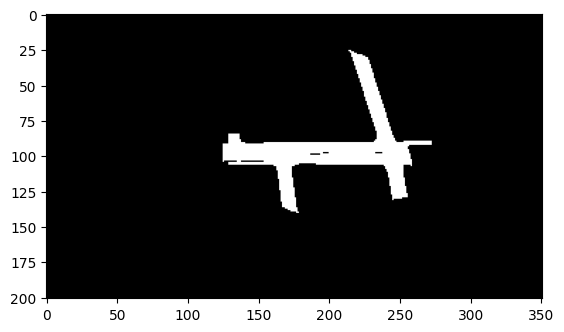

In [217]:
import av2.utils.raster as raster_utils

data_split = "val"
dataroot =  f"{data_split}"
log_ids = glob.glob(f"{dataroot}/*")
filenr = 15
log_dir_ = (log_ids[filenr].split('\\')[-1])
argoverse_scenario_dir = Path(log_ids[filenr])#/ log_id
static_map = ArgoverseStaticMap.from_json(argoverse_scenario_dir/f"log_map_archive_{log_dir_}.json")

scenario_path = argoverse_scenario_dir.rglob("*.parquet")
data = pd.read_parquet(next(scenario_path))

focal_track_id = (data['focal_track_id'][0])
main_data = data.loc[data['track_id'] == focal_track_id].sort_values('timestep')
h = main_data.iloc[49]['heading']
c_, s_ = np.cos(h), np.sin(h)
R_ = np.array([[c_, s_], 
                [-s_, c_]])#.transpose(2,0,1)
xyz_org = np.array([main_data.iloc[49]['position_x'],main_data.iloc[49]['position_y'],0])
lane_ploys = [(R_@(np.vstack((lane.right_lane_boundary.xyz,lane.left_lane_boundary.xyz[::-1],lane.right_lane_boundary.xyz[0]))-xyz_org).T[:2,:]).T
            for lane in static_map.get_scenario_lane_segments()]# if lane.lane_type=='VEHICLE']

x_min, y_min, x_max, y_max = -200,-100,150,100

# The resolution of the rasterization will affect image dimensions.
array_s_city = 1
img_h = int((y_max - y_min + 1) * array_s_city)
img_w = int((x_max - x_min + 1) * array_s_city)
def poly2map(polys):
    # scale determines the resolution of the raster DA layer.
    #array_Sim2_city = Sim2(R=R_mat, t=np.array([200,100]), s=array_s_city)

    # convert vertices for each polygon from a 3d array in city coordinates, to a 2d array
    # in image/array coordinates.
    da_polygons_img = [np.round((
        dapc[:, :2]+np.array([-x_min,-y_min]))*array_s_city).astype(np.int32) for dapc in polys]

    return raster_utils.get_mask_from_polygons(da_polygons_img, img_h, img_w)

raster_arr = poly2map(lane_ploys)

plt.imshow(raster_arr[::-1,:],cmap='gray')
plt.show()

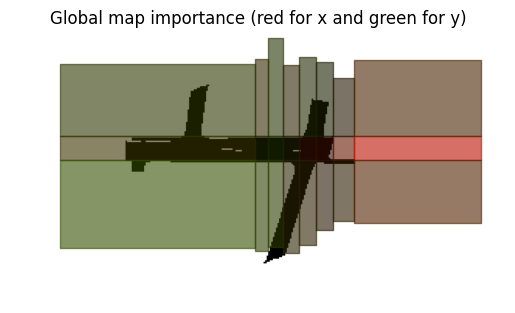

In [237]:
plt.imshow(1-raster_arr[::-1,:],cmap='gray')
plt.axis('off')
plt.title('Global map importance (red for x and green for y)')



scores = global_ex_x.data()['scores'][0:]
scores_y = global_ex_y.data()['scores'][0:]
names = global_ex_y.data()['names'][0:]

    
for i,sub_mode_x in enumerate(new_sub_modes_x):#x
    sub_mode = np.array(sub_mode_x)
    xmin,xmax = sub_mode[:,0].min(),sub_mode[:,0].max()
    ymin,ymax = sub_mode[:,1].min(),sub_mode[:,1].max()
    
    
    #if i == 0:
    #    plt.plot([0,0],[0,ymax-ymin],'g',linewidth=1)
    #plt.plot([xmax-x_min,xmax-x_min],[0,ymax-y_min],'g',linewidth=1)
    offset = i*y_ranges
    for j in range(y_ranges):
        mode = sub_modes[offset+j]
        #print(len(mode))
        if len(mode)==0:
            continue
        ymin,ymax = mode[:,1].min(),mode[:,1].max()
        #print(xmin,xmax,ymin,ymax)
        #xmin,xmax = mode[:,0].min(),mode[:,0].max()
        #if j==(y_ranges-1):
        try:
            mode_indx = names.index(f'mode{j+(y_ranges*i)}x')
            clr_red = (scores[mode_indx]+scores[mode_indx+1])/3
            clr_green = (scores_y[mode_indx]+scores_y[mode_indx+1])/3
        except ValueError:
            clr_red = 1
            clr_green = 1
        plt.fill_between([xmin+200,xmax+200],y1=100-ymin,y2=100-ymax,color=[clr_red,clr_green,0],cmap='hot',alpha=0.6)#color=[1-map_y[offset+j],0,0]
#print(raster_arr.shape)
plt.xlim([50,370])
plt.ylim([0,175])
plt.show()

C:\Users\yasin\AppData\Local\Temp\ipykernel_2096\4205754764.py:65: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

C:\Users\yasin\AppData\Local\Temp\ipykernel_2096\4205754764.py:79: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



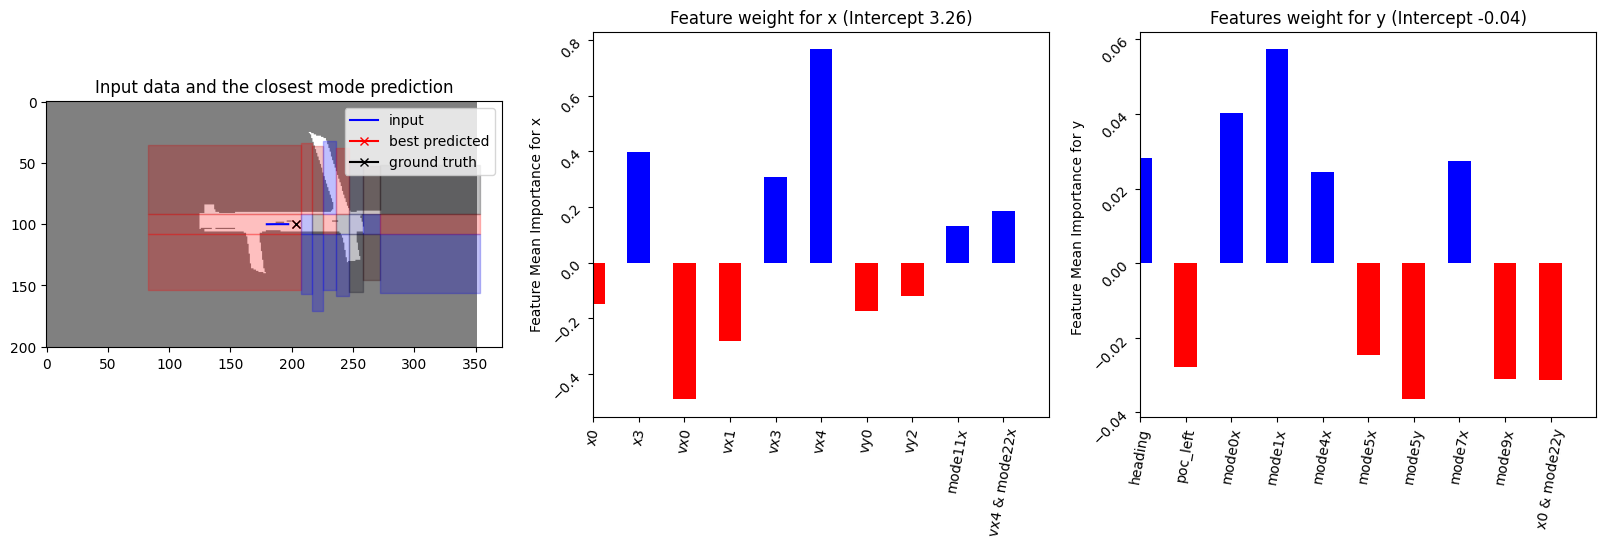

In [219]:
key_ = filenr-1

pred_20 = get_all_modes(YsXs_test[key_:key_+1,:])
best_mode = np.linalg.norm(pred_20 - YsXs_test[key_,:2],axis=1).argmin()
local_ex_x_mode = GAMs_x[best_mode].explain_local(YsXs_test[:key_+2,2:])
local_ex_y_mode = GAMs_y[best_mode].explain_local(YsXs_test[:key_+2,2:])

data_x = local_ex_x_mode.data(key=key_)
data_y = local_ex_y_mode.data(key=key_)
names = data_x['names']
input_data = [[],[]]

# draw input 
input_data = [YsXs_test[key_,2:6]+200,YsXs_test[key_,6:10]+100]
#for s_ in range(0):
#    f_ind_x = names.index(f'x{s_}')
#    f_ind_y = names.index(f'y{s_}')
#    input_data[0].append(data_x['values'][f_ind_x])
#    input_data[1].append(data_x['values'][f_ind_y])
    
plt.figure(figsize=(20,5))
plt.title(f'global models ex {key_}')
plt.subplot(131)
plt.plot(input_data[0],input_data[1],color='b',label='input')
#draw output
scores = np.array(data_x['scores'])
scores_y = np.array(data_y['scores'])
#plt.plot(data_x['perf']['predicted'],data_y['perf']['predicted'],marker='x',color='r',label='predicted')
plt.plot(data_x['perf']['predicted']+200,data_y['perf']['predicted']+100,marker='x',color='r',label='best predicted')
plt.plot(YsXs_test[key_,0]+200,YsXs_test[key_,1]+100,marker='x',color='k',label='ground truth')
plt.imshow(raster_arr[::-1,:],cmap='gray',alpha=0.5)
#plt.axis('off')
for i,sub_mode_x in enumerate(new_sub_modes_x):#x       
    sub_mode = np.array(sub_mode_x)
    xmin,xmax = sub_mode[:,0].min(),sub_mode[:,0].max()
    offset = i*y_ranges
    for j in range(y_ranges):
        mode = sub_modes[offset+j]
        if len(mode)==0:continue
        ymin,ymax = mode[:,1].min(),mode[:,1].max()
        try:
            mode_indx = names.index(f'mode{j+(y_ranges*i)}x')
            clr_red = scores[mode_indx]+scores[mode_indx+1]
            #clr_red = scores_y[mode_indx]+scores_y[mode_indx+1]
            clr_red *= 20
        except ValueError:
            clr_red = 1
        if clr_red>0: clr=[0,0,min(clr_red,0.99)]
        else: clr=[min(abs(clr_red),0.99),0,0]
        #print(clr_red)
        plt.fill_between([xmin+200,xmax+200],y1=100-ymin,y2=100-ymax,color=clr,cmap='hot',alpha=0.25)
        
plt.legend()
#plt.ylim([-1,1])
plt.title('Input data and the closest mode prediction')
#plt.axis('square')

#plt.show()

plt.subplot(132)
#draw best 10 amounts to x

mask_best_6 = np.sort(np.abs(scores))[-11]<np.abs(scores)

plt.bar(range(0,len(scores[mask_best_6])*10,10),scores[mask_best_6],width=5,align='center',color=[['r','b'][x>0] for x in scores[mask_best_6]])
plt.xticks(np.arange(0,len(scores[mask_best_6])*10,10),np.array(names)[mask_best_6],rotation=80)
plt.xlim(0,len(scores[mask_best_6])*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for x')
plt.title(f'Feature weight for x (Intercept {np.round(data_x["extra"]["scores"][0],decimals=2)})')
#plt.ylim([-1,1])
#plt.show()

plt.subplot(133)
#draw best 10 amounts to y
scores = np.array(data_y['scores'])
mask_best_6 = np.sort(np.abs(scores))[-11]<np.abs(scores)

plt.bar(range(0,len(scores[mask_best_6])*10,10),scores[mask_best_6],width=5,align='center',color=[['r','b'][x>0] for x in scores[mask_best_6]])
plt.xticks(np.arange(0,len(scores[mask_best_6])*10,10),np.array(names)[mask_best_6],rotation=80)
plt.xlim(0,len(scores[mask_best_6])*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for y ')
plt.title(f'Features weight for y (Intercept {np.round(data_y["extra"]["scores"][-1],decimals=2)})')
#plt.ylim([-1,1])

plt.show()